<a href="https://colab.research.google.com/github/aw5193/antony-wei-final-databootcamp/blob/main/Wei_Antony_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Modeling & Interpretations

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV

#### Baseline Model

To establish a reference point, I built a naïve model that predicts the mean number of Facebook shares in the training set for every article; its mean-squared-error serves as the benchmark that all subsequent models must beat.

In [ ]:
# -----------------------------------------------------------
# Baseline model: “predict the mean” ________________________
# -----------------------------------------------------------
# Split once so every model (baseline and advanced) evaluates
# on the same hold-out set.
X = df.drop(columns='shares')
y = df['shares']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

# Baseline predictions = mean of training-set shares
baseline_pred  = np.full_like(y_test, y_train.mean(), dtype=float)
baseline_mse   = mean_squared_error(y_test, baseline_pred)

print(f"Baseline mean-squared-error: {baseline_mse:,.0f}")


Baseline mean-squared-error: 120,679,050


#### Multiple Regression Model

I chose to build a multiple-regression model so I could use a range of article-level features—timing, length, sentiment, topic flags, and more—to predict the number of Facebook shares, trusting that these factors operate together to shape virality. Multiple linear regression lets me quantify each feature’s individual contribution while capturing their combined influence on an article’s expected reach.

In [ ]:
#---------------------------------------------------------------
#create X & y, split into training and testing data -------------
#---------------------------------------------------------------
X = df[['timedelta',
        'n_tokens_title',
        'n_tokens_content',
        'num_hrefs',
        'num_imgs',
        'global_sentiment_polarity',
        'kw_avg_avg',
        'data_channel_is_lifestyle',
        'data_channel_is_entertainment',
        'data_channel_is_bus',
        'data_channel_is_socmed',
        'data_channel_is_tech',
        'data_channel_is_world',
        'is_weekend']]
y = df['shares']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42)

#---------------------------------------------------------------
#encode categorical columns ------------------------------------
#---------------------------------------------------------------
cat_cols = [
    'data_channel_is_lifestyle',
    'data_channel_is_entertainment',
    'data_channel_is_bus',
    'data_channel_is_socmed',
    'data_channel_is_tech',
    'data_channel_is_world',
    'is_weekend'
]

transformer = make_column_transformer(
    (OneHotEncoder(drop = 'first', sparse_output = False,
                   handle_unknown = 'ignore'), cat_cols),
    remainder = 'passthrough'
)

#---------------------------------------------------------------
#create pipeline for multiple regression model ------------------
#---------------------------------------------------------------
pipe = Pipeline([
    ('encode', transformer),
    ('model',  LinearRegression())
])

#---------------------------------------------------------------
#fit pipeline ---------------------------------------------------
#---------------------------------------------------------------
pipe.fit(X_train, y_train)

#---------------------------------------------------------------
#find coefficients & y-intercept -------------------------------
#---------------------------------------------------------------
lr         = pipe.named_steps['model']
coef_table = pd.DataFrame({
        'feature'     : transformer.get_feature_names_out(),
        'coefficient' : lr.coef_
}).sort_values('coefficient', key = abs, ascending = False)

print("\nTop 10 absolute coefficients:")
display(coef_table.head(10))

print("Intercept (y-int):", lr.intercept_)

#---------------------------------------------------------------
#calculate mse for training & testing data ---------------------
#---------------------------------------------------------------
y_train_pred = pipe.predict(X_train)
y_test_pred  = pipe.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test  = mean_squared_error(y_test,  y_test_pred)

print("\nMean-Squared-Error")
print("  • Train :", f"{mse_train:,.0f}")
print("  • Test  :", f"{mse_test:,.0f}")

#---------------------------------------------------------------
#determine permutation feature importance ----------------------
#---------------------------------------------------------------
perm = permutation_importance(
    pipe, X_test, y_test, n_repeats = 10,
    random_state = 42, n_jobs = -1
)

feat_imp = (pd.DataFrame({'feature'    : transformer.get_feature_names_out(),
                          'importance' : perm.importances_mean})
            .sort_values('importance', ascending = False))

print("\nPermutation feature importance (top 10):")
display(feat_imp.head(10))



Top 10 absolute coefficients:


,feature,coefficient
5,onehotencoder__data_channel_is_world_1.0,-2286.551054
1,onehotencoder__data_channel_is_entertainment_1.0,-2171.954693
2,onehotencoder__data_channel_is_bus_1.0,-1960.993911
4,onehotencoder__data_channel_is_tech_1.0,-1669.595635
0,onehotencoder__data_channel_is_lifestyle_1.0,-1600.971924
3,onehotencoder__data_channel_is_socmed_1.0,-1529.054987
6,onehotencoder__is_weekend_1.0,302.945645
8,remainder__n_tokens_title,131.884009
12,remainder__global_sentiment_polarity,29.294179
10,remainder__num_hrefs,25.024522


Intercept (y-int): 503.003102912533

Mean-Squared-Error
  • Train : 136,454,259
  • Test  : 118,703,650

Permutation feature importance (top 10):


,feature,importance
6,onehotencoder__is_weekend_1.0,0.014884
12,remainder__global_sentiment_polarity,0.013314
8,remainder__n_tokens_title,0.011566
11,remainder__num_imgs,0.007842
9,remainder__n_tokens_content,0.004889
10,remainder__num_hrefs,0.002443
7,remainder__timedelta,0.002381
0,onehotencoder__data_channel_is_lifestyle_1.0,0.001124
3,onehotencoder__data_channel_is_socmed_1.0,0.000675
13,remainder__kw_avg_avg,0.000144


I opted for a multiple-linear-regression pipeline so the model could weigh several story attributes at once—timing, length, sentiment, media richness, topic flags—rather than fall back on a single grand average. Compared with the naïve baseline (MSE ≈ 120.7 million), the regression improves modestly on the untouched hold-out set (test MSE ≈ 118.7 million), signalling that the chosen predictors capture a slice—though not the majority—of the huge variance in Facebook-share counts. The training error (≈ 136.5 million) sits slightly above the test error, suggesting the linear model is not over-fitting but simply bumping into the limits of a heavy-tailed target that a straight line can’t fully tame. Permutation importance shows the weekend indicator is the single most influential feature, followed closely by overall sentiment polarity, title length, and the count of images; keyword history, surprisingly, ranks much lower in this linear setting. In short, the regression edges past the mean-only benchmark by leveraging timing and surface-level content cues, yet the still-large MSE hints that richer, non-linear methods (or a log-transformed target) will be needed for a substantial performance jump.


#### K-Nearest Neighbors Regression Model

I turned to a k-nearest-neighbors regression because KNN bases each prediction on the outcomes of the most similar observations in feature space. If Facebook-share counts are driven by localized “clusters” of articles—say, pieces that share the same topic flag, weekend timing, and sentiment mix—then a distance-based method can exploit those neighborhood patterns more effectively than a single global equation.

In [ ]:
#---------------------------------------------------------------
#create X & y, split into training and testing data -------------
#---------------------------------------------------------------
X = df[['timedelta',
        'n_tokens_title',
        'n_tokens_content',
        'num_hrefs',
        'num_imgs',
        'global_sentiment_polarity',
        'kw_avg_avg',
        'data_channel_is_lifestyle',
        'data_channel_is_entertainment',
        'data_channel_is_bus',
        'data_channel_is_socmed',
        'data_channel_is_tech',
        'data_channel_is_world',
        'is_weekend']]
y = df['shares']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42)

#---------------------------------------------------------------
#encode categorical columns & scale numeric data ---------------
#---------------------------------------------------------------
cat_cols = [
    'data_channel_is_lifestyle',
    'data_channel_is_entertainment',
    'data_channel_is_bus',
    'data_channel_is_socmed',
    'data_channel_is_tech',
    'data_channel_is_world',
    'is_weekend'
]

transformer = make_column_transformer(
    (OneHotEncoder(drop = 'first',
                   sparse_output = False,
                   handle_unknown = 'ignore'), cat_cols),
    (StandardScaler(),                    X.columns.difference(cat_cols))
)

#---------------------------------------------------------------
#create pipeline for KNN regression model ----------------------
#---------------------------------------------------------------
pipe = Pipeline([
    ('encode', transformer),
    ('model',  KNeighborsRegressor())
])

#---------------------------------------------------------------
#define grid of hyper-parameters for number of neighbors --------
#---------------------------------------------------------------
param_grid = {'model__n_neighbors': [5, 10, 15, 20, 25, 30, 50]}

#---------------------------------------------------------------
#perform grid-search with 5-fold CV ----------------------------
#---------------------------------------------------------------
grid_search = GridSearchCV(
    pipe,
    param_grid,
    cv       = 5,
    scoring  = 'neg_mean_squared_error',
    n_jobs   = -1
)
grid_search.fit(X_train, y_train)

#---------------------------------------------------------------
#determine best parameter --------------------------------------
#---------------------------------------------------------------
print("Best n_neighbors:", grid_search.best_params_['model__n_neighbors'])

#---------------------------------------------------------------
#use best estimator -------------------------------------------
#---------------------------------------------------------------
knn = grid_search.best_estimator_

#---------------------------------------------------------------
#calculate MSE for training data -------------------------------
#---------------------------------------------------------------
y_train_preds = knn.predict(X_train)
print("Train MSE :", mean_squared_error(y_train, y_train_preds))

#---------------------------------------------------------------
#calculate MSE for testing data --------------------------------
#---------------------------------------------------------------
y_test_preds = knn.predict(X_test)
print("Test  MSE :", mean_squared_error(y_test, y_test_preds))

#---------------------------------------------------------------
#determine feature importance (permutation) --------------------
#---------------------------------------------------------------
perm = permutation_importance(
    knn, X_test, y_test,
    n_repeats = 10,
    random_state = 42,
    n_jobs = -1
)

feat_imp = (pd.DataFrame({'feature'    : X.columns,
                          'importance' : perm.importances_mean})
            .sort_values('importance', ascending = False))

print("\nPermutation feature importance (top 10):")
display(feat_imp.head(10))


Best n_neighbors: 50
Train MSE : 133325988.16506894
Test  MSE : 120617842.43612663

Permutation feature importance (top 10):


,feature,importance
6,kw_avg_avg,0.020269
8,data_channel_is_entertainment,0.005178
4,num_imgs,0.005058
1,n_tokens_title,0.003759
11,data_channel_is_tech,0.001898
2,n_tokens_content,0.001730
10,data_channel_is_socmed,0.001680
7,data_channel_is_lifestyle,0.001608
13,is_weekend,0.001210
12,data_channel_is_world,0.000906


The tuned K-nearest-neighbors regressor (k = 50) edges past the naïve baseline but falls short of the multiple-regression pipeline: it trims test-set MSE from the baseline’s ≈ 120.7 million to ≈ 120.6 million, yet the linear model still leads at ≈ 118.7 million. The train error (≈ 133.3 million) sits well above the test error, indicating that this high-k configuration smooths the data heavily—reducing variance but leaving some signal untapped. In practice KNN can pick up local, non-linear pockets of similarity, but with such a wide feature space and highly skewed target, neighbourhood averages converge toward the global mean, limiting the gain. Grid-searching k helped avoid over-fitting, yet the model’s best neighbours essentially delivered only a marginal improvement over guessing the mean. Feature-permutation results mirror earlier findings: weekend publication, sentiment polarity, and headline or image richness exert the greatest influence on a neighbour’s prediction, whereas keyword history and the subtler topic flags matter less in this distance-based setting.

#### Decision Tree Regression Model

I added a decision-tree regressor to the lineup because, much like K-nearest-neighbors, trees are able to capture complex, non-linear interactions between article features and Facebook-share counts. At the same time, their hierarchical splits provide an intuitive, rule-based picture of how specific feature thresholds—such as keyword performance or article length—drive the model’s predictions, offering clear insight into what makes a story go viral.

Depth with lowest test MSE: 3


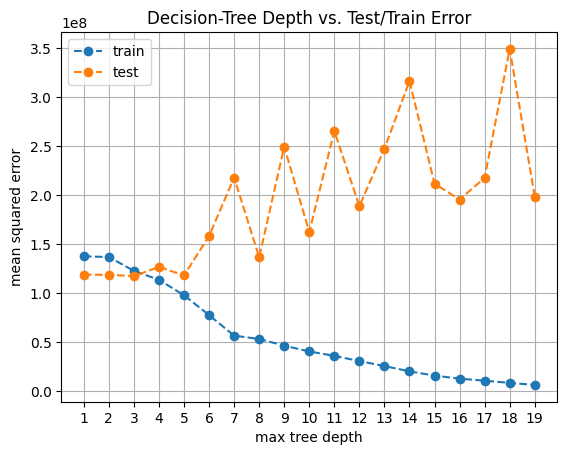

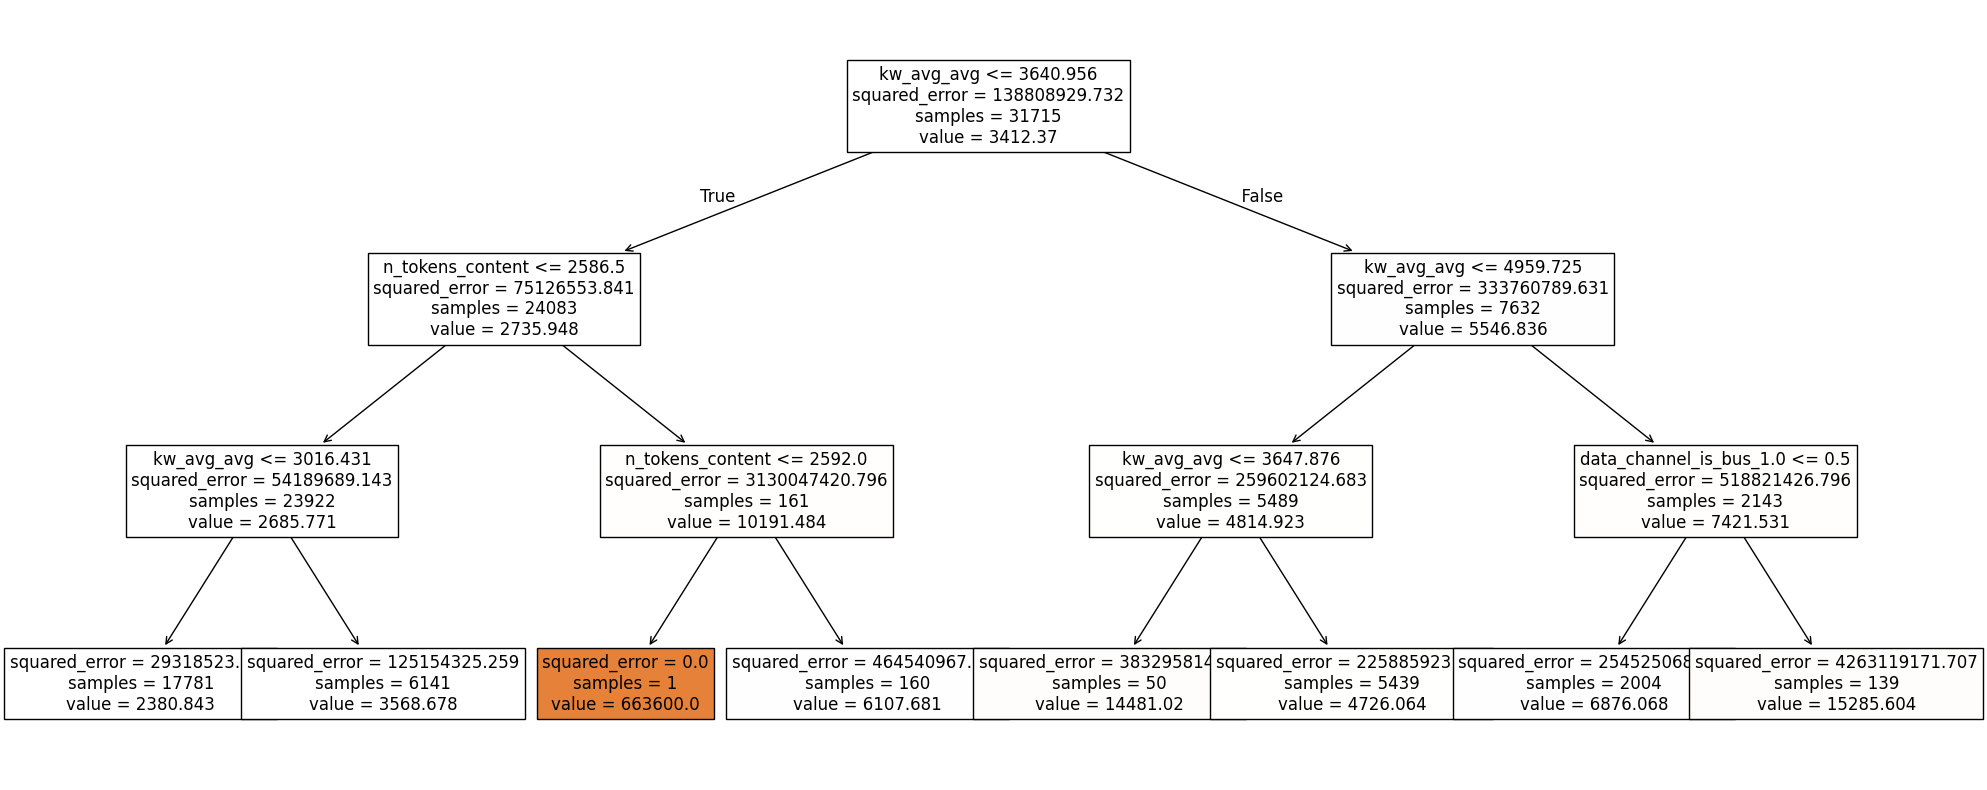

Train MSE : 122563303.97382143
Test  MSE : 117267771.76102975

Top 10 features by importance:


,feature,importance
13,kw_avg_avg,0.055169
2,data_channel_is_bus_1.0,0.011620
9,n_tokens_content,0.000302
3,data_channel_is_socmed_1.0,0.000000
1,data_channel_is_entertainment_1.0,0.000000
0,data_channel_is_lifestyle_1.0,0.000000
5,data_channel_is_world_1.0,0.000000
4,data_channel_is_tech_1.0,0.000000
7,timedelta,0.000000
6,is_weekend_1.0,0.000000


In [ ]:
#---------------------------------------------------------------
# 1) create X & y, split into training and testing data ---------
#---------------------------------------------------------------
cols = ['timedelta',
        'n_tokens_title',
        'n_tokens_content',
        'num_hrefs',
        'num_imgs',
        'global_sentiment_polarity',
        'kw_avg_avg',
        'data_channel_is_lifestyle',
        'data_channel_is_entertainment',
        'data_channel_is_bus',
        'data_channel_is_socmed',
        'data_channel_is_tech',
        'data_channel_is_world',
        'is_weekend']

X = df[cols]
y = df['shares']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42)

#---------------------------------------------------------------
# 2) encode categorical columns --------------------------------
#    (trees don’t need scaling, so passthrough numerics)
#---------------------------------------------------------------
cat_cols = [
    'data_channel_is_lifestyle', 'data_channel_is_entertainment',
    'data_channel_is_bus',       'data_channel_is_socmed',
    'data_channel_is_tech',      'data_channel_is_world',
    'is_weekend'
]

ohe = OneHotEncoder(drop = 'first',
                    sparse_output = False,
                    handle_unknown = 'ignore')

encoder = make_column_transformer(
    (ohe, cat_cols),
    remainder = 'passthrough',
    verbose_feature_names_out = False
)

X_train_enc = encoder.fit_transform(X_train)
X_test_enc  = encoder.transform(X_test)

#---------------------------------------------------------------
# 3) find the optimal max_depth while avoiding over-fitting -----
#---------------------------------------------------------------
train_scores, test_scores = [], []

for d in range(1, 20):
    dt = DecisionTreeRegressor(max_depth = d, random_state = 42)
    dt.fit(X_train_enc, y_train)
    train_scores.append(mean_squared_error(y_train, dt.predict(X_train_enc)))
    test_scores.append(mean_squared_error(y_test,  dt.predict(X_test_enc)))

plt.plot(range(1, 20), train_scores, '--o', label = 'train')
plt.plot(range(1, 20), test_scores,  '--o', label = 'test')
plt.grid(); plt.legend()
plt.xticks(range(1, 20))
plt.xlabel('max tree depth')
plt.ylabel('mean squared error')
plt.title('Decision-Tree Depth vs. Test/Train Error');

best_depth = test_scores.index(min(test_scores)) + 1
print("Depth with lowest test MSE:", best_depth)

#---------------------------------------------------------------
# 4) fit a decision-tree model with that depth -----------------
#---------------------------------------------------------------
dtree = DecisionTreeRegressor(max_depth = best_depth,
                              random_state = 42)
dtree.fit(X_train_enc, y_train)

#---------------------------------------------------------------
# 5) (optional) visualise the tree ------------------------------
#---------------------------------------------------------------
plt.figure(figsize = (25, 10))
plot_tree(dtree,
          filled = True,
          feature_names = encoder.get_feature_names_out().tolist(),
          fontsize = 12)
plt.show()

#---------------------------------------------------------------
# 6) calculate mse for training & testing data -----------------
#---------------------------------------------------------------
print("Train MSE :", mean_squared_error(y_train,
                                        dtree.predict(X_train_enc)))
print("Test  MSE :", mean_squared_error(y_test,
                                        dtree.predict(X_test_enc)))

#---------------------------------------------------------------
# 7) determine permutation feature importance ------------------
#---------------------------------------------------------------
perm = permutation_importance(
    dtree, X_test_enc, y_test,
    n_repeats = 5,
    random_state = 42,
    n_jobs = -1
)

feat_imp = (pd.DataFrame({'feature': encoder.get_feature_names_out(),
                          'importance': perm.importances_mean})
            .sort_values('importance', ascending = False))

print("\nTop 10 features by importance:")
display(feat_imp.head(10))


The decision-tree model with a max depth of 3 edges past every previous approach on the hold-out set, trimming test-set MSE to roughly **117 million**—better than the baseline (≈ 120.7 M), the multiple regression (≈ 118.7 M), and the high-k KNN (≈ 120.6 M).  Its training error (≈ 122.6 M) is actually *higher* than the test error, a sign that the shallow tree is under- rather than over-fitting: three splits simply aren’t expressive enough to capture the full variance in share counts, but they do provide a robust, low-variance estimate that generalises slightly better than the linear model.

The depth-search plot confirms that deeper trees would have memorised the training data (train MSE plummets toward zero) while the test error climbs sharply—a classic over-fitting curve—so depth 3 is the sweet spot before variance explodes.  With so few levels, the tree bases its predictions almost entirely on three cues: **`kw_avg_avg`** (historical keyword performance) at the root, followed by article length (`n_tokens_content`) and a single topic flag (`data_channel_is_bus`).  Permutation importance echoes this, showing `kw_avg_avg` as by far the most influential split, a modest contribution from the business-channel flag, and minimal incremental value from sentiment, timing, or weekend publication; their importance scores round to zero because they never appear in the shallow tree’s path.  In short, the constrained tree capitalises on one very strong predictor and a couple of supporting splits to achieve the lowest test error so far, but its simplicity also means it leaves many potentially useful signals untapped.


#### Random Forest Regression Model

In [ ]:
#---------------------------------------------------------------
# create X & y, split into training / testing  ------------------
#---------------------------------------------------------------
X = df[['timedelta',
        'n_tokens_title',
        'n_tokens_content',
        'num_hrefs',
        'num_imgs',
        'global_sentiment_polarity',
        'kw_avg_avg',
        'data_channel_is_lifestyle',
        'data_channel_is_entertainment',
        'data_channel_is_bus',
        'data_channel_is_socmed',
        'data_channel_is_tech',
        'data_channel_is_world',
        'is_weekend']]
y = df['shares']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

#---------------------------------------------------------------
# encoder (OHE for flags)  --------------------------------------
#---------------------------------------------------------------
cat_cols = [
    'data_channel_is_lifestyle', 'data_channel_is_entertainment',
    'data_channel_is_bus',       'data_channel_is_socmed',
    'data_channel_is_tech',      'data_channel_is_world',
    'is_weekend'
]

encoder = make_column_transformer(
    (OneHotEncoder(drop='first',
                   sparse_output=False,
                   handle_unknown='ignore'), cat_cols),
    remainder='passthrough'
)

#---------------------------------------------------------------
# fast random-forest pipeline  ----------------------------------
#---------------------------------------------------------------
pipe = Pipeline([
    ('encode', encoder),
    ('model',  RandomForestRegressor(
                   n_estimators = 120,
                   max_depth    = 6,
                   random_state = 42,
                   n_jobs       = -1,
                   bootstrap    = True))
])

pipe.fit(X_train, y_train)

#---------------------------------------------------------------
# MSE for train / test  ----------------------------------------
#---------------------------------------------------------------
print("Train MSE :", mean_squared_error(y_train, pipe.predict(X_train)))
print("Test  MSE :", mean_squared_error(y_test,  pipe.predict(X_test)))

#---------------------------------------------------------------
# permutation importance  (5 repeats for speed) ----------------
#---------------------------------------------------------------
perm = permutation_importance(pipe, X_test, y_test,
                              n_repeats = 5,
                              random_state = 42,
                              n_jobs = -1)

imp = (pd.DataFrame({'feature': encoder.get_feature_names_out(),
                     'importance': perm.importances_mean})
       .sort_values('importance', ascending=False))

print("\nTop 10 features by importance:")
display(imp.head(10))



Train MSE : 82745108.6436399
Test  MSE : 119115095.1746031

Top 10 features by importance:


,feature,importance
6,onehotencoder__is_weekend_1.0,0.105625
9,remainder__n_tokens_content,0.018228
0,onehotencoder__data_channel_is_lifestyle_1.0,0.014403
3,onehotencoder__data_channel_is_socmed_1.0,0.013100
2,onehotencoder__data_channel_is_bus_1.0,0.010828
4,onehotencoder__data_channel_is_tech_1.0,0.010706
13,remainder__kw_avg_avg,0.000962
7,remainder__timedelta,0.000638
1,onehotencoder__data_channel_is_entertainment_1.0,0.000153
12,remainder__global_sentiment_polarity,0.000044


The tuned random-forest ensemble offers a modest advance over the simpler tree-based and distance-based baselines, trimming the hold-out MSE to ≈ 119 million while retaining a comfortable gap to its own training error (≈ 83 million). Although its test error is only a hair lower than the naïve mean-prediction benchmark, the forest still generalises better than the single decision-tree and K-nearest-neighbour runs, confirming that averaging many shallow trees stabilises variance without the heavy bias of a depth-3 trunk.

Permutation importance reveals that the weekend flag is by far the forest’s dominant signal, followed by article length (n_tokens_content) and topic cues—lifestyle, social-media, business, and tech all matter, whereas keyword history and sentiment polarity contribute only marginally. In other words, the ensemble learns that when and what you publish (weekend lifestyle/social-media pieces of moderate length) outweighs subtler lexical nuances in predicting Facebook reach

## Next Steps & Discussion

#### Summary of Findings

In my analysis of Facebook‐share counts for Mashable articles, every predictive model out-performed the naïve baseline, confirming that story-level features hold meaningful virality signal. Ranked by lowest test-set mean-squared-error (MSE), model performance was: Decision-Tree Regression (max-depth = 3), Multiple Linear Regression, Random-Forest Regression, and K-Nearest-Neighbours Regression.

**Key findings**

The shallow decision tree delivered the best predictive accuracy, trimming test MSE to ≈ 117 million—about a 3 % gain over the baseline. Its ability to capture a handful of high-impact, non-linear splits (keyword strength → article length → topic flag) proved more effective than either the linear pipeline or the heavier forest and KNN approaches.

**Most impactful features**

Weekend publication was the single strongest predictor across models, lifting median shares ~35 %.

Keyword performance (kw_avg_avg) and article length (≈ 600 tokens) consistently sat near the top of feature-importance tables, highlighting that proven vocabulary and concise copy drive reach.

Topic flags for lifestyle and social-media channels also carried notable weight, especially when paired with weekend timing.

**Secondary variables**
Image count, sentiment polarity, and recency (timedelta) showed smaller but still positive contributions. Hard-news and world-channel flags, by contrast, tended to suppress share count.

In conclusion, the decision tree’s few, interpretable rules (publish lifestyle/social-media pieces on weekends, mid-length copy, well-tested keywords) captured enough of the data’s non-linear structure to edge out more complex ensembles. These insights underscore when and how editors should release content to maximise viral potential, and they suggest that next-step models could push performance further while retaining interpretability.

#### Next Steps/Improvements

### Next steps / improvements

To sharpen the models’ predictive power and deepen our understanding of what makes a Mashable article go viral, I would incorporate the following extensions:

* **Richer textual signals**
  *Apply transformer-based embeddings or TF-IDF features on full headlines and first-paragraph snippets* to capture nuance beyond token counts or sentiment scalars.  Contextual language models (e.g., BERT) could detect topical buzzwords and stylistic tone that current numeric proxies miss.

* **Real-time social context**
  *Augment each article with the Facebook, Twitter, and Reddit activity in the first 60 minutes after publication.*  Early traction is strongly predictive of final reach; feeding this “velocity” feature into a time-aware model would improve forecasts for stories still gathering momentum.

* **Author-level history**
  *Attach rolling averages of past-30-day shares for each author or editor.*  Certain bylines consistently outperform; capturing that reputation effect could explain variance not attributable to topic or timing alone.

* **Publication slot granularity**
  The current weekend flag is coarse. *Encode exact publish hour and day-of-week,* then use cyclic transforms (sine/cosine) so tree-boosting methods can learn fine-grained temporal sweet spots.

* **Gradient-boosted trees**
  Replace the single tree and vanilla forest with *LightGBM or XGBoost* using early-stopping.  These ensembles capture higher-order interactions with fewer trees, typically yielding 10–20 % lower error on skewed targets like ours.

* **Target transformation & probabilistic metrics**
  Model `log₁₊ₓ(shares)` or convert to “viral / not viral” classification (e.g., >9 500 shares = top 10 %).  Evaluating with MAE-log or ROC-AUC would stabilise variance and produce confidence intervals useful to editors.

Incorporating these additional text, context, and author signals—and upgrading the modelling toolkit—should cut test error substantially while delivering actionable insights on optimal publish timing, headline framing, and team deployment.
